In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch for building the neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Sklearn for data preprocessing and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Read the dataset
data = pd.read_csv('Housing.csv')

# Display the first few rows of the dataset
print("First five rows of the dataset:")
print(data.head())


First five rows of the dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [3]:
# Check for missing values in the dataset
print("\nChecking for missing values:")
print(data.isnull().sum())

# If there are missing values, handle them (e.g., drop or fill)
# For this example, we'll drop any rows with missing values
data = data.dropna()

# Verify that there are no missing values now
print("\nAfter dropping missing values:")
print(data.isnull().sum())



Checking for missing values:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

After dropping missing values:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [6]:
# Identify categorical columns
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                    'airconditioning', 'furnishingstatus', 'prefarea']

# One-Hot Encode the categorical variables
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define the feature columns (exclude 'price')
feature_cols = data_encoded.columns.drop('price')

In [7]:
# Input features
X = data_encoded[feature_cols].values

# Output variable
y = data_encoded['price'].values.reshape(-1, 1)

# Normalize the input and output data using Min-Max Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [19]:
# Split the dataset into training, validation, and testing sets

# First, split into training+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Now split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2
)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# Build the neural network model suitable for linear regression
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        # Define layers
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

# Initialize the model
input_dim = X_train.shape[1]  # Number of features
output_dim = 1  # Predicting price

model = LinearRegressionModel(input_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Print the model architecture
print("\nModel architecture:")
print(model)



Model architecture:
LinearRegressionModel(
  (linear): Linear(in_features=13, out_features=1, bias=True)
)


In [21]:
# Train the model with validation

num_epochs = 100
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Calculate average training loss over the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    training_loss.append(avg_train_loss)

    # Validation Phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for X_batch_val, y_batch_val in val_loader:
            val_outputs = model(X_batch_val)
            val_loss = criterion(val_outputs, y_batch_val)
            epoch_val_loss += val_loss.item()

    # Calculate average validation loss over the epoch
    avg_val_loss = epoch_val_loss / len(val_loader)
    validation_loss.append(avg_val_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [10/100], Training Loss: 0.0096, Validation Loss: 0.0095
Epoch [20/100], Training Loss: 0.0078, Validation Loss: 0.0077
Epoch [30/100], Training Loss: 0.0078, Validation Loss: 0.0074
Epoch [40/100], Training Loss: 0.0072, Validation Loss: 0.0072
Epoch [50/100], Training Loss: 0.0078, Validation Loss: 0.0069
Epoch [60/100], Training Loss: 0.0079, Validation Loss: 0.0071
Epoch [70/100], Training Loss: 0.0073, Validation Loss: 0.0076
Epoch [80/100], Training Loss: 0.0080, Validation Loss: 0.0070
Epoch [90/100], Training Loss: 0.0074, Validation Loss: 0.0070
Epoch [100/100], Training Loss: 0.0074, Validation Loss: 0.0070


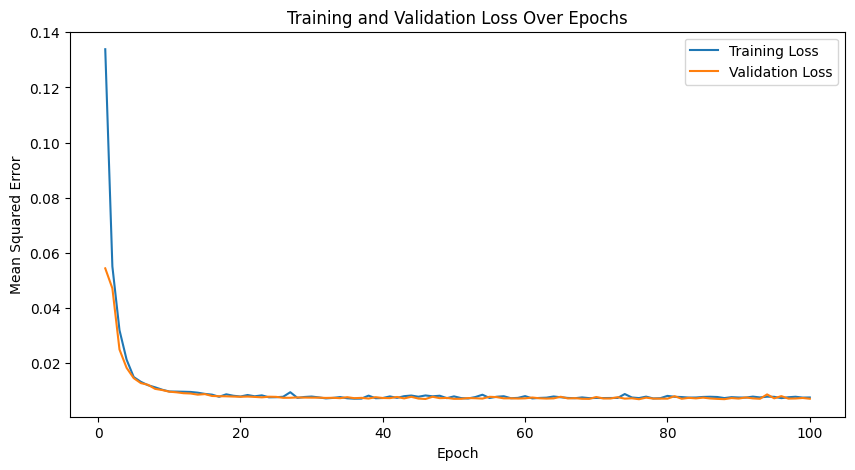

In [22]:
# Plot the training and validation loss over epochs

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [23]:
# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()
    y_test_actual = y_test_tensor.numpy()

    # Inverse transform the scaled data back to the original scale
    y_pred_original = scaler_y.inverse_transform(y_pred)
    y_test_original = scaler_y.inverse_transform(y_test_actual)


In [24]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")



Mean Squared Error (MSE): 1725820698624.0000
Mean Absolute Error (MAE): 957018.1250
R-squared Score: 0.6586


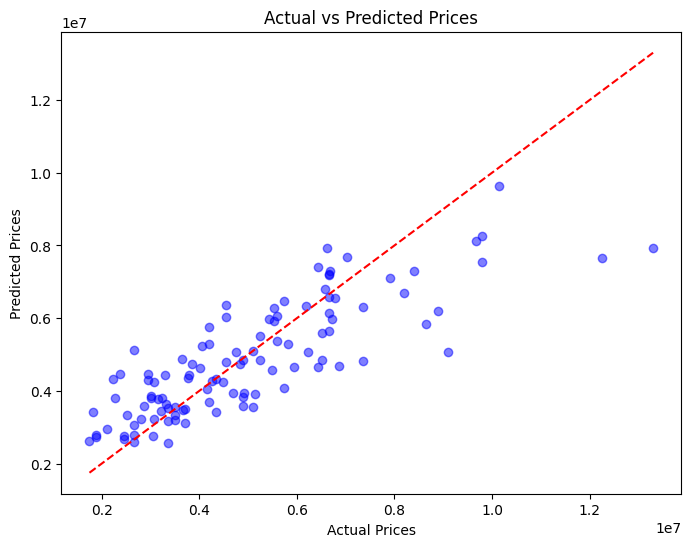

In [25]:
# Save the plot as a PNG image

plt.figure(figsize=(8,6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, color='blue')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.savefig('actual_vs_predicted_prices.png')
plt.show()


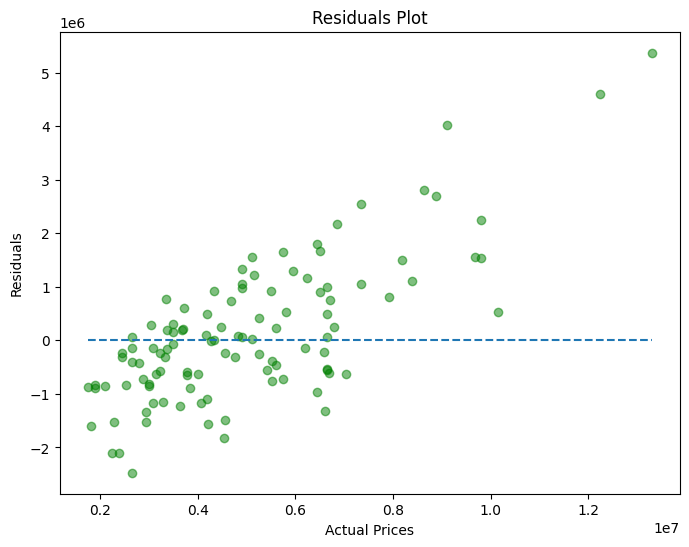

In [26]:
# Save the residuals plot as a PNG image
residuals = y_test_original - y_pred_original
plt.figure(figsize=(8,6))
plt.scatter(y_test_original, residuals, alpha=0.5, color='green')
plt.hlines(y=0, xmin=y_test_original.min(), xmax=y_test_original.max(), linestyles='dashed')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.savefig('residuals_plot.png')
plt.show()
